# Load library

In [1]:
import cv2
import numpy as np
import pandas as pd
import albumentations as albm
import matplotlib.pyplot as plt
# from albumentations import (
#     HorizontalFlip, RandomRotate90, Transpose, ShiftScaleRotate, 
#     RandomBrightnessContrast, Blur, OpticalDistortion, GridDistortion, 
#     HueSaturationValue, Compose
# )
import os
import re

/opt/homebrew/Caskroom/miniforge/base/envs/pyenv_312/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Read image

In [8]:
# Define directory to search and substring to look for
search_dir = os.getcwd()
sub_str_dir_name = 'crm-'

# Find all directory names containing substring
label_dir = [
    dir_name for dir_name in os.listdir(search_dir)
    if os.path.isdir(os.path.join(search_dir, dir_name)) and sub_str_dir_name in dir_name
]

# Output the list of matching directories
# Define a key function to extract numeric parts for sorting
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

label_dir.sort(key=natural_sort_key)

for label_dir_name in label_dir:
    
    for image_file in os.listdir(f'{label_dir_name}'):
        
         if image_file.endswith('.tif'):

            image_file_path = os.path.join(label_dir_name, image_file)

            # Read an image to apply augmentations
            original_image = cv2.imread('crm-top-5/crm-top-5-original-image-1.tif')

            # Convert the original image in BGR format into the most common RGB format
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Show the original image
            # plt.imshow(original_image)
            # plt.axis('off')
            # plt.show()

label_dir

['crm-bottom-5',
 'crm-bottom-10',
 'crm-bottom-15',
 'crm-bottom-20',
 'crm-top-5',
 'crm-top-10',
 'crm-top-15',
 'crm-top-20']

# Manipulate image

## Convert RGB to Grayscale 

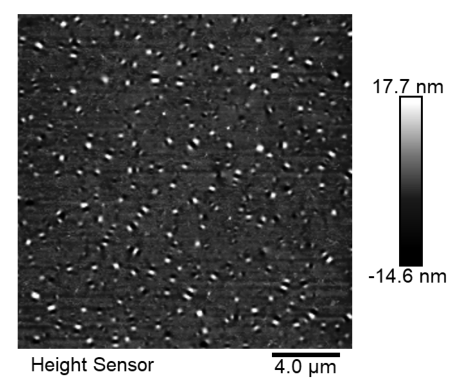

In [3]:
# Convert RGB image to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

## Inverse grayscale image

retval, dst = cv2.threshold(src, thresh, maxval, type)
- src: The source image, which must be a single-channel (grayscale) image.
- thresh: The threshold value. Any pixel value above this threshold will be set to maxval, and any pixel value below or equal to this - threshold will be set to 0.
- maxval: The value to be assigned to pixels that exceed the threshold.
- type: The type of thresholding to be applied. In this case, cv2.THRESH_BINARY is used.

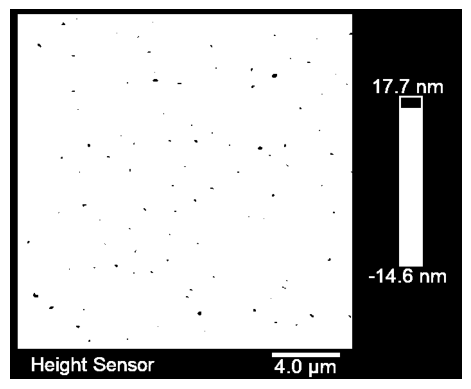

In [4]:
# Inverse darker regions to white ones to get the mask of the originally colored regions
# if pixel intensity is greater than threshold (darker), 240, then it sets to zero (white)
_, mask = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY_INV)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

colored image starts at 8 and ends at 529 in y-axis.
colored image starts at 12 and ends at 533 in x-axis.


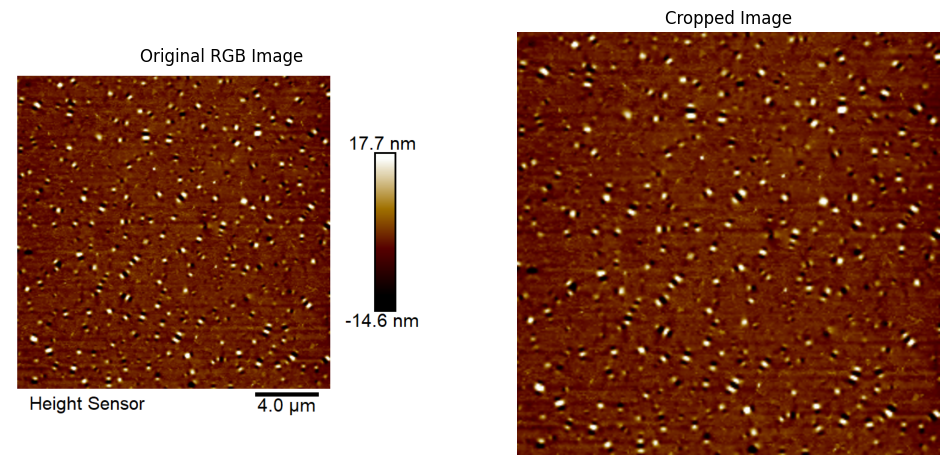

In [5]:
# Initialize coordinates of crop region of image to zero
y0 = 0
y1 = 0
x0 = 0
x1 = 0

summed_list = [sum(elements) for elements in zip(*mask)]

# Find crop points in height
for h in range(len(mask)):
    
    # find y-axis point where colored image begins by comparing it to white background
    if y0 == 0 and mask[h].sum() != 0:
        y0 = h
        
    # find y-axis point where colored image ends by comparing it to white background
    elif y0 != 0 and y1 == 0 and mask[h].sum() == 0:
        y1 = h
        
        # Find crop points in width
        for w in range(len(summed_list)):
            
            if summed_list[w] != 0:     # point where colored section starts
                x0 = w
                
                for z in range(len(summed_list[x0:])):
                    if summed_list[x0+z] == 0:
                        x1 = x0+z
                        break;
                break;
        break;

print(f'colored image starts at {y0} and ends at {y1} in y-axis.')
print(f'colored image starts at {x0} and ends at {x1} in x-axis.')

# Display the original and grayscale images
plt.figure(figsize=(12, 6))

# Original RGB Image
plt.subplot(1, 2, 1)
plt.title('Original RGB Image')
plt.imshow(original_image)
plt.axis('off')

# Cropped Image
plt.subplot(1, 2, 2)
plt.title('Cropped Image')
plt.imshow(original_image[y0:y1, x0:x1])
plt.axis('off')
plt.show()

In [6]:
cropped_image = cv2.cvtColor(original_image[y0:y1, x0:x1], cv2.COLOR_RGB2BGR)
cv2.imwrite('crm-top-5-crop-example.jpg', cropped_image)

True

# Augment image

## Build a pipeline for augmentations

### Geometric Transformation

In [7]:
# transform = albm.Compose([
#     albm.Rotate(limit=1, p=1.0),
#     albm.Affine(shear=0, p=1.0),
#     albm.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=1.0),
#     albm.HorizontalFlip(p=1.0),
#     albm.VerticalFlip(p=1.0)
#     albm.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, p=0.5)
#     albm.Affine(scale=1.0, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, interpolation=1, mode=0, cval=0, fit_output=False, always_apply=False, p=0.5)
# ])

## Load manipulated (cropped) image 

In [8]:
image = cv2.imread('crm-top-5-crop-example.jpg')
# augmented = transform(image=image)
# random_cropped_image = augmented['image']

In [9]:
# Display the original and cropped images
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.subplot(1, 2, 2)
# plt.title('Augemented Image (RandomCrop)')
# plt.imshow(cv2.cvtColor(random_cropped_image, cv2.COLOR_BGR2RGB))
# plt.show()

### Sub-Sampling 

#### Sliding window (Fixed grid cropping) 

In [10]:
crop_height = 224
crop_width = 224
step_size = 64

In [11]:
image = cv2.imread('crm-top-5-crop-example.jpg')

In [12]:
def sliding_window(image, crop_height, crop_width, step_size):
    crops = []
    h, w, _ = image.shape
    print(f'Size of height of the image is {h} and size of width is {w}')

    for y in range(0, h - crop_height + 1, step_size):
        for x in range(0, w - crop_width + 1, step_size):
            # Define the cropping transformation
            transform = albm.Crop(x_min=x, y_min=y, x_max=x+crop_width, y_max=y+crop_height, always_apply=True)
            # Apply the crop
            cropped = transform(image=image)
            crops.append(cropped['image'])
    print(f'The amount of generated images is {len(crops)}')
    return crops

Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
The amount of train images is 18
The amount of val images is 7


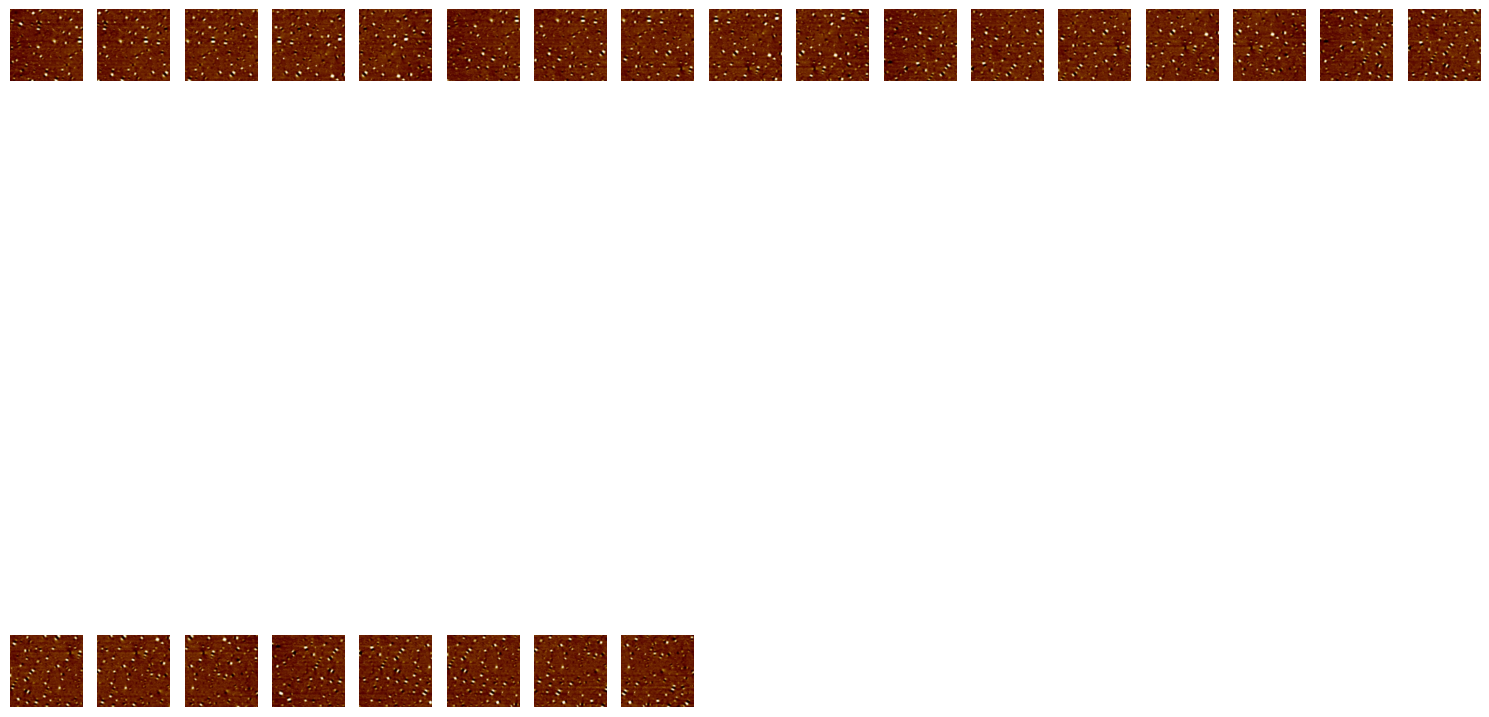

In [16]:
# Get crops using sliding window approach
crops = sliding_window(image, crop_height, crop_width, step_size)
num_train = round(len(crops) * 0.7)
num_val = len(crops) - num_train

print(f'The amount of train images is {num_train}')
print(f'The amount of val images is {num_val}')

# Display all cropped images
plt.figure(figsize=(15, 15))
num_crops = len(crops)
cols = 17  # Number of columns for display
rows = (num_crops // cols) + (num_crops % cols > 0)  # Calculate number of rows needed

for i, crop in enumerate(crops):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.tight_layout()
plt.show()

### Save augmented images

In [38]:
# Directory to save cropped images
save_dir = '../images/crm_top_5/augmented-images'
os.makedirs(save_dir, exist_ok=True)

# Save all cropped images
for i, crop in enumerate(crops):
    save_path = os.path.join(save_dir, f'crm-top-5-crop-aug-{i + 1}.jpg')
    cv2.imwrite(save_path, crop)

print(f"Saved {len(crops)} cropped images to {save_dir}")

Saved 289 cropped images to ../images/crm_top_5/augmented-images


In [60]:
import random

def generate_random_with_average(n, min_val, max_val, label_avg):
    # Start with a list of random values between min_val and max_val
    values = [random.uniform(min_val, max_val) for _ in range(n)]
    # Scale the values to adjust the average
    current_avg = sum(values) / n
    scaling_factor = label_avg / current_avg
    scaled_values = [round(min(max(v * scaling_factor, min_val), max_val), 2) for v in values]
    return scaled_values

# Parameters
n = 100
min_val = 1.12
max_val = 1.16
label_avg = 1.14

values = generate_random_with_average(n, min_val, max_val, label_avg)
print(f"Generated Values: {values}")
print(f"Average: {sum(values)/n}")

Generated Values: [1.13, 1.15, 1.16, 1.14, 1.14, 1.13, 1.16, 1.16, 1.14, 1.12, 1.15, 1.14, 1.13, 1.13, 1.14, 1.13, 1.15, 1.15, 1.12, 1.14, 1.16, 1.16, 1.15, 1.15, 1.13, 1.14, 1.13, 1.13, 1.15, 1.13, 1.16, 1.13, 1.15, 1.15, 1.13, 1.14, 1.16, 1.15, 1.13, 1.13, 1.14, 1.13, 1.14, 1.16, 1.14, 1.14, 1.13, 1.16, 1.13, 1.14, 1.13, 1.13, 1.13, 1.14, 1.15, 1.16, 1.13, 1.14, 1.15, 1.13, 1.15, 1.13, 1.14, 1.16, 1.13, 1.12, 1.14, 1.16, 1.14, 1.15, 1.16, 1.16, 1.13, 1.13, 1.14, 1.14, 1.12, 1.15, 1.13, 1.13, 1.13, 1.16, 1.14, 1.15, 1.14, 1.13, 1.12, 1.14, 1.13, 1.15, 1.13, 1.16, 1.12, 1.13, 1.13, 1.14, 1.14, 1.12, 1.13, 1.13]
Average: 1.1399999999999997


In [ ]:
import random

def generate_random_with_average(n, min_val, max_val, label_avg):
    # Start with a list of random values between min_val and max_val
    values = [random.uniform(min_val, max_val) for _ in range(n)]
    # Scale the values to adjust the average
    current_avg = sum(values) / n
    scaling_factor = label_avg / current_avg
    scaled_values = [round(min(max(v * scaling_factor, min_val), max_val), 2) for v in values]
    return scaled_values

# Parameters
n = 100
min_val = 1.12
max_val = 1.16
label_avg = 1.14

values = generate_random_with_average(n, min_val, max_val, label_avg)
print(f"Generated Values: {values}")
print(f"Average: {sum(values)/n}")

# Complete Code

In [14]:
import cv2
import numpy as np
import pandas as pd
import albumentations as albm
import matplotlib.pyplot as plt
import os
import random

# Create train and val labels files
train_image_path = 'data/train'
train_label_path = "data/train.csv"
train_label = pd.DataFrame(columns=['image_name', 'label'])
train_list = []

val_image_path = 'data/val'
val_label_path = "data/val.csv"
val_label = pd.DataFrame(columns=['image_name', 'label'])
val_list = []

# Define directory to search and substring to look for
search_dir = os.getcwd()
sub_str_dir_name = 'crm-'

# Find all directory names containing substring
label_dir = [
    dir_name for dir_name in os.listdir(search_dir)
    if os.path.isdir(os.path.join(search_dir, dir_name)) and sub_str_dir_name in dir_name
]

# Output the list of matching directories in defined sorted way
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

label_dir.sort(key=natural_sort_key)


for label_dir_name in label_dir:
    for image_file in os.listdir(f'{label_dir_name}'):
         if image_file.endswith('.tif'):
             
            image_file_path = os.path.join(label_dir_name, image_file)

             # Use a regex to extract the number at the end of the file name before .tif
            match = re.search(r'-(\d+)\.tif$', image_file)
             
            if match:
                number = int(match.group(1))

            # Read an image to apply augmentations
            # original_image = cv2.imread(f'{directory}/{directory}-original-image-1.tif')
            original_image = cv2.imread(image_file_path)
   
            # Convert the original image in BGR format into the most common RGB format
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            
            # Convert RGB image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
            
            # Inverse darker regions to white ones to get the mask of the originally colored regions
            # if pixel intensity is greater than threshold (darker), 240, then it sets to zero (white)
            _, mask = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY_INV)
            
            # Initialize coordinates of crop region of image to zero
            y0 = 0
            y1 = 0
            x0 = 0
            x1 = 0
            
            summed_list = [sum(elements) for elements in zip(*mask)]
            
            # Find crop points in height
            for h in range(len(mask)):
                
                # find y-axis point where colored image begins by comparing it to white background
                if y0 == 0 and mask[h].sum() != 0:
                    y0 = h
                    
                # find y-axis point where colored image ends by comparing it to white background
                elif y0 != 0 and y1 == 0 and mask[h].sum() == 0:
                    y1 = h
                    
                    # Find crop points in width
                    for w in range(len(summed_list)):
                        
                        if summed_list[w] != 0:     # point where colored section starts
                            x0 = w
                            
                            for z in range(len(summed_list[x0:])):
                                if summed_list[x0+z] == 0:
                                    x1 = x0+z
                                    break;
                            break;
                    break;
            
            cropped_image = cv2.cvtColor(original_image[y0:y1, x0:x1], cv2.COLOR_RGB2BGR)
            cv2.imwrite(f'{label_dir_name}/{label_dir_name}-crop-image-{number}.jpg', cropped_image)
        
            # image size: 256
            # height & width is recommended to be 224 for ResNet 50 as the model is pretrained with the size of 224
            crop_height = 224     # 78
            crop_width = 224      # 78
            step_size =64
            
            image = cv2.imread(f'{label_dir_name}/{label_dir_name}-crop-image-{number}.jpg')
            
            def sliding_window(image, crop_height, crop_width, step_size):
                crops = []
                h, w, _ = image.shape
                print(f'Size of height of the image is {h} and size of width is {w}')
            
                for y in range(0, h - crop_height + 1, step_size):
                    for x in range(0, w - crop_width + 1, step_size):
                        # Define the cropping transformation
                        transform = albm.Crop(x_min=x, y_min=y, x_max=x+crop_width, y_max=y+crop_height, always_apply=True)
                        # Apply the crop
                        cropped = transform(image=image)
                        crops.append(cropped['image'])
                print(f'The amount of generated images is {len(crops)}')
                return crops
            
            # Get crops using sliding window approach
            crops = sliding_window(image, crop_height, crop_width, step_size)
            num_train = round(len(crops) * 0.7)
            num_val = len(crops) - num_train
 
            # Directory to save cropped images
            save_dir = [train_image_path, val_image_path]
            for save_dir_name in save_dir:
                os.makedirs(save_dir_name, exist_ok=True)
            
            # Save all cropped images
            for i, crop in enumerate(crops):
                if label_dir_name == 'crm-top-5':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                elif label_dir_name == 'crm-top-10':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                elif label_dir_name == 'crm-top-15':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.38})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                elif label_dir_name == 'crm-top-20':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 24.97})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                elif label_dir_name == 'crm-bottom-5':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 16.75})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                elif label_dir_name == 'arm-bottom-10':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 77.77})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                elif label_dir_name == 'arm-bottom-15':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 93.52})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
                elif label_dir_name == 'arm-bottom-20':
                    if i <= (num_train - 1):
                        train_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 93.76})
                    else:
                        val_list.append({'image_name':f'{label_dir_name}-crop-aug-image-{i + 1}.jpg', 'label': 1.14})
            
                if i <= (num_train - 1):
                    save_path = os.path.join(save_dir[0], f'{label_dir_name}-crop-aug-image-{i + 1}.jpg')
                else:
                    save_path = os.path.join(save_dir[1], f'{label_dir_name}-crop-aug-image-{i + 1}.jpg')
                    
                cv2.imwrite(save_path, crop)
  
    train_label = pd.concat([train_label, pd.DataFrame(train_list)], ignore_index=True)
    train_label.to_csv(train_label_path, index=False)

    val_label = pd.concat([val_label, pd.DataFrame(val_list)], ignore_index=True)
    val_label.to_csv(val_label_path, index=False)
    # print(f"Saved {len(crops)} cropped images to {save_dir}")

Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25


/var/folders/l2/7n23zrdj0638vdghhrgkvjwr0000gn/T/ipykernel_16036/2038835379.py:181: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_label = pd.concat([train_label, pd.DataFrame(train_list)], ignore_index=True)
/var/folders/l2/7n23zrdj0638vdghhrgkvjwr0000gn/T/ipykernel_16036/2038835379.py:184: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  val_label = pd.concat([val_label, pd.DataFrame(val_list)], ignore_index=True)


Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is 521 and size of width is 521
The amount of generated images is 25
Size of height of the image is